In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel, pipeline
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from torchninja import Trainer

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
df = pd.read_csv('bloom_dataset_ptbr.csv')

df.fillna(0, inplace=True)
df['one_hot'] = list(df.iloc[:, 1:-1].values)

LABELS = list(df.iloc[:, 1:-1])
print(LABELS)

df.head()

['remember', 'understand', 'apply', 'analyze', 'evaluate', 'create']


,text,remember,understand,apply,analyze,evaluate,create,one_hot
0,Analisar as implicações econômicas para a saúd...,0.0,0.0,0.0,1.0,0.0,0.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
1,Aplicar competências de investigação para func...,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,Avaliação e síntese de diversas informações so...,0.0,0.0,0.0,0.0,1.0,1.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0]"
3,Descreva as características gerais do moderno ...,0.0,1.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
4,Avaliação dos diferentes modelos de cuidados p...,0.0,0.0,0.0,0.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"


In [4]:
class BloomDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __getitem__(self, index):
        text, one_hot = df.loc[index, ['text', 'one_hot']]
        target = torch.tensor(one_hot).float()
        return text, target

    def __len__(self):
        return len(self.df)

In [5]:
LABELS = ['remember', 'understand', 'apply', 'analyze', 'evaluate', 'create']

class CognitiveClassifier(nn.Module):
    def __init__(
        self,
        num_cognitive_processes=6,
        bert_model='neuralmind/bert-base-portuguese-cased',
        freeze_bert=True,
        labels=LABELS
    ):
        super().__init__()
        self.num_cognitive_processes = num_cognitive_processes
        self.tokenizer = AutoTokenizer.from_pretrained(bert_model)
        self.encoder = AutoModel.from_pretrained(bert_model)
        self.fc = nn.Linear(self.encoder.config.hidden_size, num_cognitive_processes)
        self.labels = labels

        if freeze_bert:
            for param in self.encoder.parameters():
                param.requires_grad = False

    def forward(self, **kwargs):
        encodings = self.encoder(**kwargs).last_hidden_state
        encodings = encodings[:, 0, :]
        outputs = self.fc(encodings)
        outputs = torch.sigmoid(outputs)
        return outputs

    def encode(self, **kwargs):
        encodings = self.encoder(**kwargs).last_hidden_state
        encodings = encodings[:, 0, :]
        return encodings

    def predict(self, text, return_labels=True, threshold=0.5):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True).to(self.encoder.device)
        outputs = (self.forward(**inputs) > threshold).int().squeeze()

        if return_labels:
            outputs = [LABELS[i] for i in range(len(self.labels)) if outputs[i]]

        return outputs

In [20]:
df_train, df_test = train_test_split(df, test_size=0.2)

train_set = BloomDataset(df_train)
test_set = BloomDataset(df_test)

data_loaders = {
    'train': DataLoader(train_set, batch_size=16, shuffle=True),
    'val': DataLoader(test_set, batch_size=16, shuffle=True)
    
}
test_loader = data_loaders['val']

In [21]:
model = CognitiveClassifier(bert_model='neuralmind/bert-base-portuguese-cased', freeze_bert=False)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00002)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


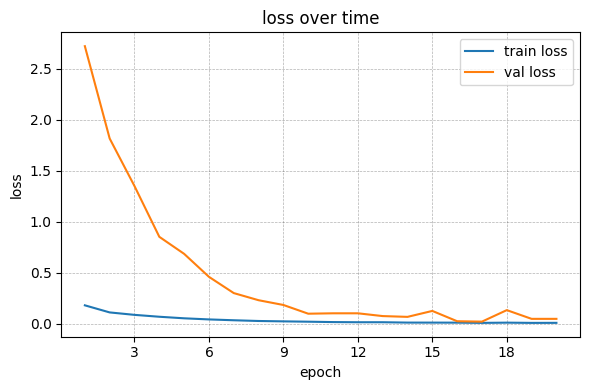

In [22]:
class BloomTrainer(Trainer):
    def training_step(self, batch, batch_idx):
        text, target = batch
        inputs = self.model.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(self.device)
        pred = self.model(**inputs)
        loss = self.criterion(pred, target)
        metrics = {'loss': loss}
        return metrics

    def validation_step(self, batch, batch_idx):
        text, target = batch
        inputs = self.model.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(self.device)
        pred = (self.model(**inputs) > 0.5).float()
        loss = self.criterion(pred, target)
        acc = ((pred == target).int().sum()/pred.numel())
        metrics = {'loss': loss, 'acc': acc}
        return metrics

    def test_step(self, batch, batch_idx):
        text, target = batch
        inputs = self.model.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(self.device)
        pred = (self.model(**inputs) > 0.5).float()
        loss = self.criterion(pred, target)
        acc = ((pred == target).int().sum()/pred.numel())
        metrics = {'loss': loss, 'acc': acc}
        return metrics

trainer = BloomTrainer(
    run_name='bloom_classifier_pt_2',
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    use_mixed_precision=False,
    data_loaders=data_loaders,
    log_to='file',
)

metrics = trainer.train(epochs=20)

In [23]:
metrics

{'train': {'loss': [0.17932893813241854,
   0.10971666779978963,
   0.0857899336935386,
   0.06724552774385412,
   0.05199089691816534,
   0.04106239817289059,
   0.03280828529237042,
   0.02567995322948379,
   0.02198639693491377,
   0.018726225708671423,
   0.014965029014209137,
   0.013401628577000557,
   0.013479608081898001,
   0.009954183142171813,
   0.009784424913153261,
   0.009373668852084472,
   0.007096188772997712,
   0.009417916621572457,
   0.00708109343091093,
   0.007466813932568047]},
 'val': {'loss': [2.7207712691221664,
   1.8151431226018648,
   1.3487252041475097,
   0.8512127426133227,
   0.6840796443953443,
   0.45864430915063886,
   0.2992848469250238,
   0.22932215590975177,
   0.1826803613064894,
   0.09717040542346328,
   0.10105722164040182,
   0.10105722075078025,
   0.0738495081218321,
   0.06607587568795503,
   0.124378118942033,
   0.02332089730163119,
   0.019434081084692655,
   0.13215175137591006,
   0.04664179460326238,
   0.04664179460326238],
  'ac